# Experiments Variational Repersentation


In [1]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Model implementation

In [3]:
def get_simple_model(hiddens, activation=nn.ReLU(), last_activation=None):
    assert len(hiddens) > 1
    modules = []
    for i, (in_, out_) in enumerate(zip(hiddens[:-2], hiddens[1:-1])):
        # modules.extend([nn.Linear(in_, out_), nn.ELU()]) # nn.BatchNorm1d(out_), nn.ReLU()])
        if i != len(hiddens) - 3 or not last_activation:
            modules.extend([nn.Linear(in_, out_), nn.BatchNorm1d(out_), activation])
        else:
            modules.extend([nn.Linear(in_, out_), nn.BatchNorm1d(out_), last_activation])
    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
    return nn.Sequential(*modules)

In [17]:
def visualize(cond_p, cond_q, dataset):
    circles, moons = dataset.circles[:2_000], dataset.moons[:2_000]
    
    fake_circles = pd.DataFrame(cond_p(moons).detach().numpy(), columns=['x', 'y'])
    fake_moons = pd.DataFrame(cond_q(circles).detach().numpy(), columns=['x', 'y'])
    circles = pd.DataFrame(circles, columns=['x', 'y'])
    moons = pd.DataFrame(moons, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(circles, x='x', y='y', fill=True, ax=axs[0][0])
    axs[0][0].set_title("Circles")
    sns.kdeplot(fake_circles, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    axs[0][1].set_title("Fake Circles")
    sns.kdeplot(moons, x='x', y='y', fill=True, ax=axs[1][0])
    axs[1][0].set_title("Moons")
    sns.kdeplot(fake_moons, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    axs[1][1].set_title("Fake Moons")
    plt.show()

In [18]:
# Define of divergence's conjugate function
class Conjugate(nn.Module):
    conjugates = {
        'forward_kl': lambda x: torch.exp(x - 1),
        'reverse_kl': lambda x: -1 - torch.log(-x),
        'js': lambda x: -torch.log(1 - torch.exp(x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.conjugates.keys() 
        self.conjugate = self.conjugates[divergence]

    def forward(self, x):
        return self.conjugate(x)

# Define of divergence's activation function
class Activation(nn.Module):
    activations = {
        'forward_kl': lambda x: x,
        'reverse_kl': lambda x: -torch.exp(-x),
        'js': lambda x: -torch.log(1 + torch.exp(-x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.activations.keys() 
        self.activation = self.activations[divergence]

    def forward(self, x):
        return self.activation(x)

In [19]:
class Conditional(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.in_dim = in_dim        
        self.net = get_simple_model([in_dim, 32, 32, 32, in_dim], last_activation=nn.Tanh())
        # self.net = get_simple_model([in_dim, 32, 32, 32, 2 * in_dim], last_activation=nn.Tanh())

    def forward(self, x):
        # return self.net(x).chunk(2, dim=1)
        return self.net(x)

    # def sample(self, x):
    #     mu, log_std = self(x)
    #     return torch.exp(log_std) * self._prior(self.in_dim) + mu
    #     # return mu
    #     # return self(x)

    # def _prior(self, n):
    #     return Normal(.0, 1.).sample([n])
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 2
test_cond = Conditional(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_cond(test_x)
test_cond

Conditional(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, divergence='forward_kl'):
        super().__init__()
        self.in_dim = in_dim
        
        self.conjugate = Conjugate(divergence)
        # self.net_x = get_simple_model([in_dim, 32, 32])
        # self.net_y = get_simple_model([in_dim, 32, 32])
        # self.final = get_simple_model([2 * 32, 32, 1])
        self.final = get_simple_model([2 * in_dim, 32, 32, 32, 1], nn.LeakyReLU(0.1))
        self.final.add_module("activation", Activation(divergence))

    def forward(self, x, y, conjugate=False):
        # x = self.net_x(x)
        # y = self.net_y(y)
        x_y = torch.concat([x, y], dim=1)
        return self.final(x_y) if not conjugate else self.conjugate(self.final(x_y))

############## TEST ##################
test_in_dim = 2
test_disc = Discriminator(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_y = torch.rand((4, test_in_dim))
test_disc(test_x, test_y)
test_disc

Discriminator(
  (conjugate): Conjugate()
  (final): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (activation): Activation()
  )
)

In [28]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, cond_p, cond_q, disc_b, disc_f, lr_gen=1e-4, lr_disc=1e-4):
        self.batch_size = batch_size
        self.dim  = cond_p.in_dim

        self.cond_p = cond_p # x|y
        self.cond_q = cond_q # y|x
        self.disc_b = disc_b
        self.disc_f = disc_f

        self.optim_gen = torch.optim.Adam([{'params': cond_p.parameters()},
                                            {'params': cond_q.parameters()}], lr=lr_gen) #, weight_decay=0.5, betas=(0.5, 0.999))
        self.optim_disc = torch.optim.Adam([{'params': disc_b.parameters()},
                                            {'params': disc_f.parameters()}], lr=lr_disc) #, weight_decay=0.5, betas=(0.5, 0.999))
        
    def train(self, dataloader, epochs=200, verbose=10):
        losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

        for epoch in range(epochs):
            avg_loss_cond_p, avg_loss_cond_q = 0, 0
            avg_loss_disc_b, avg_loss_disc_f = 0, 0
            
            for batch in dataloader:
                x, y = batch # circles, moons
                loss_cond_p, loss_disc_b = self._backward_step(x, y)
                avg_loss_cond_p += loss_cond_p
                avg_loss_disc_b += loss_disc_b
                
                loss_cond_q, loss_disc_f = self._forward_step(x, y)
                avg_loss_cond_q += loss_cond_q
                avg_loss_disc_f += loss_disc_f
            
            losses['cond_p'].append(avg_loss_cond_p / len(dataloader))
            losses['cond_q'].append(avg_loss_cond_q / len(dataloader))
            losses['disc_b'].append(avg_loss_disc_b / len(dataloader))
            losses['disc_f'].append(avg_loss_disc_f / len(dataloader))
            
            if (epoch + 1) % verbose == 0:
                print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')
        return losses
        
    def _backward_step(self, x, y):
        loss_cond = self._train_step_gen(y, self.cond_p, self.disc_b)
        loss_disc = self._train_step_disc(y, x, self.cond_p, self.cond_q, self.disc_b)
        return loss_cond, loss_disc

    def _forward_step(self, x, y):
        loss_cond = self._train_step_gen(x, self.cond_q, self.disc_f)
        loss_disc = self._train_step_disc(x, y, self.cond_q, self.cond_p, self.disc_f)
        return loss_cond, loss_disc
    
    def _train_step_gen(self, latent, cond, disc):
        self.optim_gen.zero_grad()

        # Generate fake samples
        generated = cond(latent)
        
        loss = disc(latent, generated).mean()
        loss.backward()
        self.optim_gen.step()
        # self.lr_scheduler_gen.step()
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, latent, real, cond, cond_fixed, disc):
        self.optim_disc.zero_grad()
        
        # calc training cond loss
        generated_real = cond(latent)
            
        loss_training = disc(latent, generated_real).mean()

        # calc fixed cond loss
        with torch.no_grad():
            generated_latent = cond_fixed(real)
        loss_fixed = disc(generated_latent, real, conjugate=True).mean()

        # combine
        loss = loss_fixed - loss_training
        loss.backward()
        self.optim_disc.step()
            
        return loss.detach().cpu().item()

Backward:
$$
\mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p(x|y)}D(x,y) - \mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q^*(y|x)}e^{D(x,y)-1}
$$

Forward:
$$
\mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q(y|x)}D(x,y) - \mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p^*(x|y)}e^{D(x,y)-1}
$$

Algorithm:
1. Sample real $x$, $y$
2. Sample fake $x$, $y$ from conditional pdf $p(x|y)$ and $q(y|x)$
3. Calculate expectation loss

## Dataloader

In [29]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float32)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float32)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

## Training

In [30]:
# Models parameters
data_dim = 2
divergence='forward_kl'

conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)


# Trainer and dataloader parameters
batch_size = 128

dataset = MoonCircleDataset(60_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen=1e-4, lr_disc=1e-4
)
losses = trainer.train(dataloader, epochs=20, verbose=1)

Iteration: 1; cond_p: 0.4383767272935493, cond_q: 0.3160805613535252, disc_f: 0.17818810357086695, disc_b: 0.10814760943084384
Iteration: 2; cond_p: 0.9333513775614025, cond_q: 0.8019100370437606, disc_f: -0.016488054922140484, disc_b: -0.057957906585766564
Iteration: 3; cond_p: 1.0942447857816082, cond_q: 1.0538459868827608, disc_f: -0.08161163736762268, disc_b: -0.10389476468059808
Iteration: 4; cond_p: 1.1609138344396661, cond_q: 1.0340829825858826, disc_f: -0.030737457244889313, disc_b: -0.12444918801281243
Iteration: 5; cond_p: 1.1714843539540956, cond_q: 1.0582335005436878, disc_f: -0.061316535416950806, disc_b: -0.15099082788678883
Iteration: 6; cond_p: 1.2021339597986704, cond_q: 1.090954570119569, disc_f: -0.09350053969222599, disc_b: -0.1646361636962972
Iteration: 7; cond_p: 1.194399444787487, cond_q: 1.1093765589982463, disc_f: -0.09309318985766185, disc_b: -0.16206209504528085
Iteration: 8; cond_p: 1.2062748662952676, cond_q: 1.091661698020089, disc_f: -0.09545047171334468,

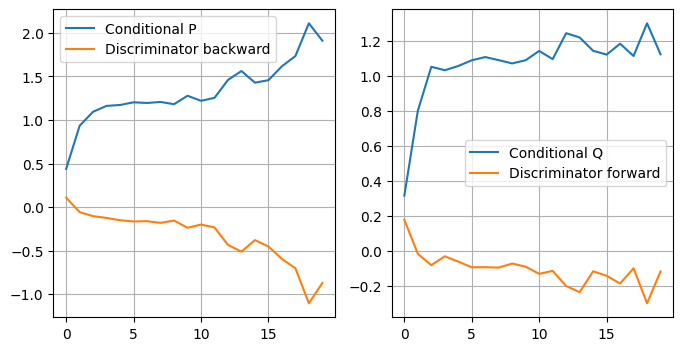

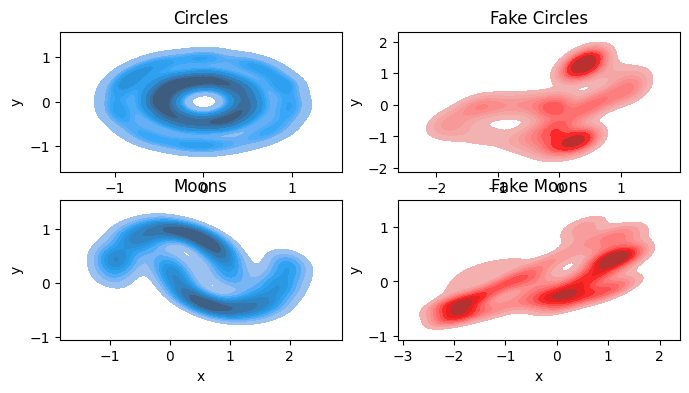

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# Plot losses
axs[0].plot(losses['cond_p'], label='Conditional P')
axs[0].plot(losses['disc_b'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

axs[1].plot(losses['cond_q'], label='Conditional Q')
axs[1].plot(losses['disc_f'], label='Discriminator forward')
axs[1].grid()
axs[1].legend()

# plt.grid()
# plt.legend()
visualize(conditional_p, conditional_q, dataset)

### For onevariate dataset calculate kl div using marginal and conditional

In [32]:
class OneVariateDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = Normal(-2, 1).sample([size, 1])
        self.moons = Normal(5, 1).sample([size, 1])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

In [37]:
# Models parameters
data_dim = 1
divergence='forward_kl'

conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)

# Trainer and dataloader parameters
batch_size = 2048

dataset = OneVariateDataset(10_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen=1e-3, lr_disc=1e-3
)
losses = trainer.train(dataloader, epochs=1000, verbose=100)

Iteration: 100; cond_p: 1.0464494943618774, cond_q: 1.2997609853744507, disc_f: -0.22588882446289063, disc_b: -0.008610236644744872
Iteration: 200; cond_p: 1.1531779050827027, cond_q: 0.9825557470321655, disc_f: -0.016481566429138183, disc_b: 0.20111007690429689
Iteration: 300; cond_p: 1.04434175491333, cond_q: 1.1896436929702758, disc_f: -0.21651290655136107, disc_b: -0.13984293937683107
Iteration: 400; cond_p: 1.0423487424850464, cond_q: 0.5551256120204926, disc_f: 0.4664125680923462, disc_b: -0.25136585235595704
Iteration: 500; cond_p: 4.327390384674072, cond_q: 1.096688175201416, disc_f: -0.19577814340591432, disc_b: -3.0723978996276857
Iteration: 600; cond_p: 1.654440951347351, cond_q: 0.8631159663200378, disc_f: 0.13406078815460204, disc_b: -0.6121483206748962
Iteration: 700; cond_p: 2.6375801086425783, cond_q: 1.050287914276123, disc_f: -0.09736645221710205, disc_b: -1.8143964767456056
Iteration: 800; cond_p: 3.239191484451294, cond_q: 0.9278390526771545, disc_f: -0.022753989696

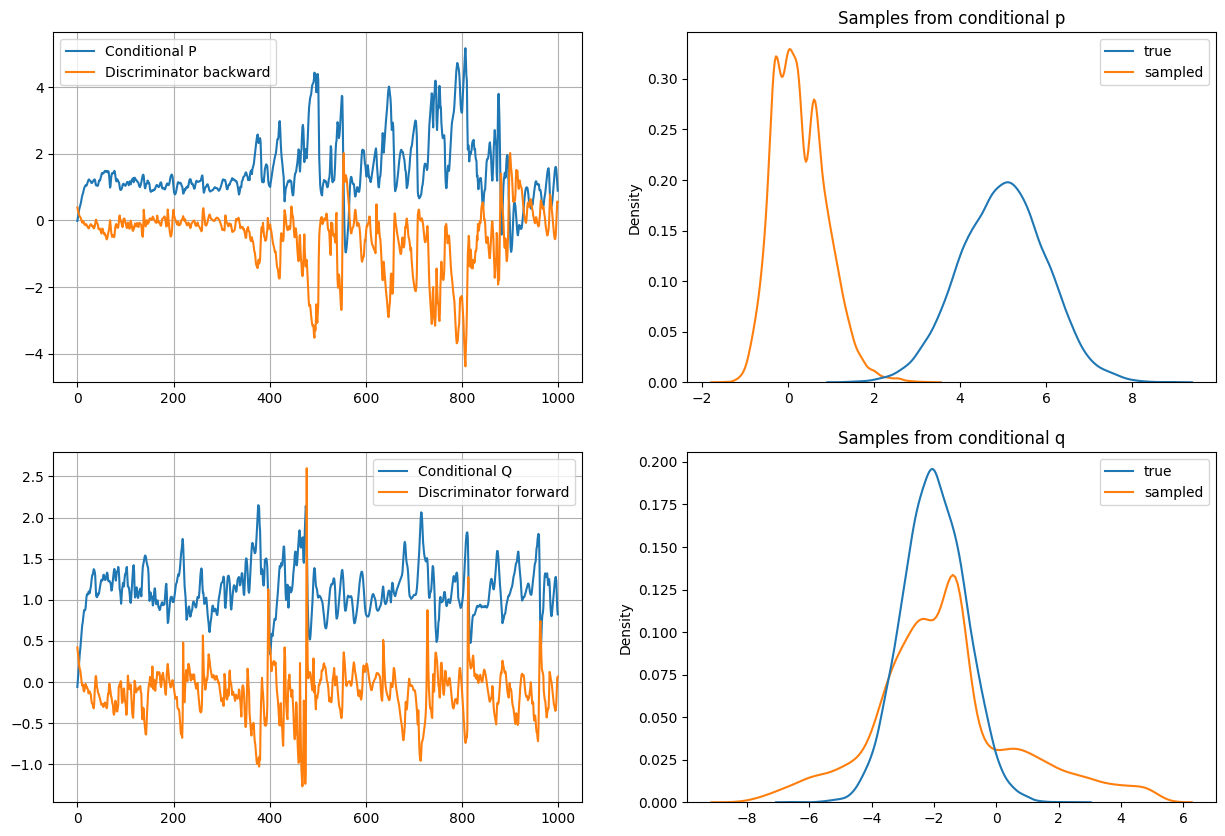

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 2000
true_x, true_y = dataset[:]

sampled_x = conditional_q(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q")

sampled_y = conditional_p(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p")

plt.show()